В этом проекте построим модель для предсказания медианы времени первого ответа в зависимости от количества активных клиентов и агентов на смене.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from pandas import Series
pd.options.mode.chained_assignment = None
import plotly.express as px
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import pprint
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
intercom2020 = pd.read_csv('/content/inbox-data-export.csv') #выгрузка по диалогам за 2020
transactions = pd.read_csv('/content/transactions.csv') #активные клиенты и их транзакции с момента запуска карточной программы

In [3]:
intercom2020['Created at'] = pd.to_datetime(intercom2020['Created at'])
transactions['created_at'] = pd.to_datetime(transactions['created_at'])

In [4]:
intercom_from_august = intercom2020[(intercom2020['Created at'] > 
                                     '2020-08-01T00:50:03.286012') & 
                                    (intercom2020['Created at'] < 
                                     '2021-01-01T00:50:03.286012')]
transactions_2020 = transactions[transactions['created_at'] < '2021-01-01']

In [5]:
intercom_from_august['If_user'] = intercom_from_august['User ID'].str.isdigit()
intercom_users = intercom_from_august[intercom_from_august['If_user'] == True]
transactions_2020 = transactions_2020.reset_index(drop=True)
transactions_2020.columns = ['User ID', 'created_at', 'reference_type']
intercom_users['User ID'] = intercom_users['User ID'].astype(int)
transactions_2020['User ID'] = transactions_2020['User ID'].astype(int)

In [6]:
#модель линейной регрессии
def perform_linear_regression(X, Y, xlabel, ylabel):
  X = X.reshape(-1, 1)
  Y = Y.reshape(-1, 1)
  #2: Split on train and test
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 124)
  #3. Create empty model
  linear_regressor = LinearRegression()  # create an instance of the class
  #4. Fit the model
  linear_regressor.fit(X_train, Y_train)  # perform linear regression
  #5. Predict Test outcomes and calculate error
  Y_pred = linear_regressor.predict(X_test)  # make predictions
  print('Средняя квадратичная ошибка:', mse(Y_test, Y_pred))
  print('Средняя абсолютная ошибка:', mae(Y_test, Y_pred))

  plt.figure(figsize=(10,6))
  plt.scatter(X_test,Y_test)

  plt.plot(X_test,Y_pred, c='red')
  

  plt.title('График линейной регрессии')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  
  plt.show()

  return linear_regressor

## Подготовим данные для построения модели линейной регресси для предсказания медианы времени первого ответа



In [7]:
Aug_dec = pd.read_csv('/content/Aug-Dec.csv') # датафрейм с датами и количеством агентов поддержки в дневную и вечернюю смены
Aug_dec['Date'] = pd.to_datetime(Aug_dec['Date'])

In [8]:
Aug_dec.columns = ['Date_only', 'Morning', 'Evening']
Aug_dec

,Date_only,Morning,Evening
0,2020-08-01,2,0
1,2020-08-02,3,0
2,2020-08-03,6,4
3,2020-08-04,6,4
4,2020-08-05,4,4
...,...,...,...
148,2020-12-27,5,0
149,2020-12-28,3,2
150,2020-12-29,5,3
151,2020-12-30,5,1


In [9]:
intercom_aug_dec = intercom_from_august
intercom_aug_dec['Date_only'] = intercom_from_august['Created at'].dt.date
intercom_aug_dec['Month'] = intercom_aug_dec['Created at'].dt.month
intercom_aug_dec # выгрузка из интеркома с августа по декабрь

,Conversation ID,Conversation URL,Title,Conversation status,Conversation tags,Created at,Last updated at,Time Zone,Inbound/Outbound,Reopened,Closed,Conversation rating,Conversation rating remark,Email,Location,Name,Type,Participated (name),User ID,Assigned to (name),Closed by (name),Teammates participated,Time to first reply (seconds),Time to last close (seconds),Teammate replies,Channel,Source,If_user,Date_only,Month
0,19131500062955,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,NaN,2020-11-01 07:19:36,2020-11-01 15:13:55,London,Inbound,0,1,NaN,NaN,kconnect@mailfence.com,United Kingdom,NaN,User,NaN,826481,Valerie,Valerie,Valerie,7445.0,20279.0,1,Desktop,Article,True,2020-11-01,11
1,19131500063032,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,NaN,2020-11-01 11:02:28,2020-11-01 12:11:21,London,Outbound,0,1,NaN,NaN,marco.luis@protonmail.com,"Windhoek, Namibia",Marco Artur Soares Marques Luis,User,Marco Artur Soares Marques Luis,561912,Renata,Renata,Renata,68.0,4133.0,1,Desktop,NaN,True,2020-11-01,11
2,19131500062837,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,NaN,2020-10-31 18:32:05,2020-11-01 10:30:27,London,Outbound,0,1,NaN,NaN,blacktear37@yahoo.com,"Athens, Greece",Gabriela Alina Chira,User,Gabriela Alina Chira,532836,First level support,Alina,NaN,NaN,701.0,0,Desktop,NaN,True,2020-10-31,10
3,19131500062826,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,NaN,2020-10-31 17:58:39,2020-11-01 09:09:53,London,Inbound,0,1,NaN,NaN,NaN,"Istanbul, Turkey",NaN,Lead,NaN,f7ce5635-00c2-4f7b-8d31-11d0100b0c03,Alina,Alina,Alina,593.0,593.0,1,Desktop,NaN,False,2020-10-31,10
4,19131500062661,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,**EU_card**,2020-10-31 10:47:26,2020-10-31 11:07:46,London,Inbound,0,1,NaN,NaN,NaN,"Ludhiana, India",NaN,Lead,NaN,aed96b41-cbf7-42a7-9ee9-95929d225a0f,Daniel,Daniel,Daniel,688.0,1220.0,1,Desktop,NaN,False,2020-10-31,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37957,19131500080798,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Snoozed,**EU_card**,2020-12-07 14:31:14,2021-01-17 16:26:38,London,Inbound,1,2,NaN,NaN,cc.oscar.carlson@gmail.com,"Stockholm, Sweden",Oscar Carl Christer Carlson,User,Oscar Carl Christer Carlson,823429,Daniel,Daniel,Daniel,168.0,1037.0,5,Desktop,NaN,True,2020-12-07,12
37959,19131500087271,https://app.intercom.com/a/apps/h202fg1c/inbox...,WG: Cryptopay-Konto geschlossen,Open,NaN,2020-12-19 21:52:10,2021-01-18 06:00:16,London,Inbound,1,1,NaN,NaN,souveraen.peter@aon.at,"Greith, Austria",Peter Heiss,User,Peter Heiss,120151,Konstantin,Daniel,"Daniel,Konstantin",3578.0,15477.0,6,Email,NaN,True,2020-12-19,12
37960,19131500066811,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,"**EU_card**, i-want-to-manage-btc-addresses-i-...",2020-11-10 15:25:19,2020-12-18 10:25:01,London,Inbound,0,7,NaN,NaN,pandabulltrader@gmail.com,United Kingdom,Allan James Irving,User,Allan James Irving,795598,Alex,Alex,"Renata,Luda,Alex",27.0,1378782.0,12,Android App,NaN,True,2020-11-10,11
37961,19131500086023,https://app.intercom.com/a/apps/h202fg1c/inbox...,NaN,Closed,*bank_transfers*,2020-12-17 16:04:02,2020-12-18 10:30:48,London,Inbound,0,1,NaN,NaN,pandabulltrader@gmail.com,United Kingdom,Allan James Irving,User,Allan James Irving,795598,Alyona,NaN,Alyona,4439.0,NaN,7,Android App,NaN,True,2020-12-17,12


In [10]:
intercom_aug_dec['Minutes to first reply'] = intercom_aug_dec['Time to first reply (seconds)'] / 60

In [11]:
#Создадим отдельную таблицу и расчитаем среднее и медиану времени первого ответа и пользовательского рейтинга, и количество входящих обращений по дням
pivot_by_date = intercom_aug_dec.pivot_table(index='Date_only', \
                                         aggfunc={'Minutes to first reply': ['mean', 'median'], \
                                                  'Conversation rating' : ['mean', 'median'],
                                                  'Conversation ID' : 'count'})
pivot_by_date


Conversation ID  ... Minutes to first reply
                     count  ...                 median
Date_only                   ...                       
2020-08-01              63  ...               6.466667
2020-08-02              59  ...              12.333333
2020-08-03             103  ...               9.766667
2020-08-04              82  ...               8.175000
2020-08-05             101  ...               7.083333
...                    ...  ...                    ...
2020-12-27             114  ...              10.833333
2020-12-28             163  ...               9.933333
2020-12-29             187  ...               9.083333
2020-12-30             170  ...               7.716667
2020-12-31             158  ...              27.466667

[153 rows x 5 columns]

In [12]:
pivot_by_date.columns = pivot_by_date.columns.droplevel()

In [13]:
pivot_by_date.columns= ['Num_of_chats', 'Rating_mean', 'Rating_median', 'FRT_mean', 'FRT_median']
pivot_by_date = pivot_by_date.reset_index()

In [14]:
pivot_by_date['Date_only'] = pd.to_datetime(pivot_by_date['Date_only'])

In [15]:
# смерджим с таблицей с количеством агентов поддержки на смене
pivot_by_date = pivot_by_date.merge(Aug_dec, how='inner', on='Date_only')
pivot_by_date

,Date_only,Num_of_chats,Rating_mean,Rating_median,FRT_mean,FRT_median,Morning,Evening
0,2020-08-01,63,4.444444,5.0,29.154333,6.466667,2,0
1,2020-08-02,59,4.500000,4.5,25.752593,12.333333,3,0
2,2020-08-03,103,4.900000,5.0,27.674603,9.766667,6,4
3,2020-08-04,82,4.000000,4.5,28.561111,8.175000,6,4
4,2020-08-05,101,3.857143,4.0,11.982917,7.083333,4,4
...,...,...,...,...,...,...,...,...
148,2020-12-27,114,4.600000,5.0,110.054167,10.833333,5,0
149,2020-12-28,163,4.483871,5.0,186.036483,9.933333,3,2
150,2020-12-29,187,4.500000,5.0,91.885600,9.083333,5,3
151,2020-12-30,170,4.320000,5.0,129.150751,7.716667,5,1


In [16]:
transactions_2020['Created_at_month'] = transactions_2020['created_at'].dt.month

In [17]:
# выгрузим таблицу с активными клиентами с августа по декабрь
transactions_aug_dec = transactions_2020[transactions_2020['Created_at_month'] > 7]
transactions_aug_dec

,User ID,created_at,reference_type,Created_at_month
0,825332,2020-12-31 23:58:01.447844,CoinDeposit,12
1,775239,2020-12-31 23:50:02.474147,CoinDeposit,12
2,460300,2020-12-31 23:48:45.844693,CoinDeposit,12
3,709924,2020-12-31 23:48:18.293100,CoinWithdrawal,12
4,825332,2020-12-31 23:48:01.497127,CoinDeposit,12
...,...,...,...,...
115128,799363,2020-08-16 01:09:06.341664,CoinWithdrawal,8
115129,799363,2020-08-16 01:08:00.378587,CardDeposit,8
115130,342927,2020-08-16 01:07:51.063378,CoinDeposit,8
115131,652216,2020-08-16 00:50:03.764868,CoinDeposit,8


In [18]:
transactions_aug_dec['Date_only'] = transactions_aug_dec['created_at'].dt.date
transactions_aug_dec

,User ID,created_at,reference_type,Created_at_month,Date_only
0,825332,2020-12-31 23:58:01.447844,CoinDeposit,12,2020-12-31
1,775239,2020-12-31 23:50:02.474147,CoinDeposit,12,2020-12-31
2,460300,2020-12-31 23:48:45.844693,CoinDeposit,12,2020-12-31
3,709924,2020-12-31 23:48:18.293100,CoinWithdrawal,12,2020-12-31
4,825332,2020-12-31 23:48:01.497127,CoinDeposit,12,2020-12-31
...,...,...,...,...,...
115128,799363,2020-08-16 01:09:06.341664,CoinWithdrawal,8,2020-08-16
115129,799363,2020-08-16 01:08:00.378587,CardDeposit,8,2020-08-16
115130,342927,2020-08-16 01:07:51.063378,CoinDeposit,8,2020-08-16
115131,652216,2020-08-16 00:50:03.764868,CoinDeposit,8,2020-08-16


In [19]:
#создадим таблицу с количеством активных клиентов по дням
pivot_active = transactions_aug_dec.pivot_table(index='Date_only', values='User ID', aggfunc='nunique')
pivot_active = pivot_active.reset_index()
pivot_active

,Date_only,User ID
0,2020-08-16,247
1,2020-08-17,340
2,2020-08-18,320
3,2020-08-19,376
4,2020-08-20,339
...,...,...
133,2020-12-27,524
134,2020-12-28,480
135,2020-12-29,542
136,2020-12-30,508


In [20]:
pivot_active['Date_only'] = pd.to_datetime(pivot_active['Date_only'])

In [21]:
# Объеденим ее с основной сводной таблицей
final_by_date = pivot_by_date.merge(pivot_active, how='inner', on='Date_only')
final_by_date

,Date_only,Num_of_chats,Rating_mean,Rating_median,FRT_mean,FRT_median,Morning,Evening,User ID
0,2020-08-16,63,5.000000,5.0,16.419811,10.333333,3,0,247
1,2020-08-17,98,4.588235,5.0,18.567671,7.333333,5,4,340
2,2020-08-18,97,4.750000,5.0,79.650192,9.033333,5,3,320
3,2020-08-19,195,4.379310,5.0,22.696391,9.633333,6,3,376
4,2020-08-20,154,4.130435,4.0,487.110267,7.550000,6,3,339
...,...,...,...,...,...,...,...,...,...
133,2020-12-27,114,4.600000,5.0,110.054167,10.833333,5,0,524
134,2020-12-28,163,4.483871,5.0,186.036483,9.933333,3,2,480
135,2020-12-29,187,4.500000,5.0,91.885600,9.083333,5,3,542
136,2020-12-30,170,4.320000,5.0,129.150751,7.716667,5,1,508


In [22]:
final_by_date.columns = ['Date', 'Num_of_chats', 'Rating_mean', 'Rating_median', 'FRT_mean', \
                         'FRT_median', 'Morning_shifts', 'Evening_shifts', \
                         'Num_of_active']

In [23]:
del final_by_date['Rating_median']
final_by_date

,Date,Num_of_chats,Rating_mean,FRT_mean,FRT_median,Morning_shifts,Evening_shifts,Num_of_active
0,2020-08-16,63,5.000000,16.419811,10.333333,3,0,247
1,2020-08-17,98,4.588235,18.567671,7.333333,5,4,340
2,2020-08-18,97,4.750000,79.650192,9.033333,5,3,320
3,2020-08-19,195,4.379310,22.696391,9.633333,6,3,376
4,2020-08-20,154,4.130435,487.110267,7.550000,6,3,339
...,...,...,...,...,...,...,...,...
133,2020-12-27,114,4.600000,110.054167,10.833333,5,0,524
134,2020-12-28,163,4.483871,186.036483,9.933333,3,2,480
135,2020-12-29,187,4.500000,91.885600,9.083333,5,3,542
136,2020-12-30,170,4.320000,129.150751,7.716667,5,1,508


In [24]:
# Посчитаем общее количество агентов на смене по дням
final_by_date['Num_of_agents'] = final_by_date['Morning_shifts'] + final_by_date['Evening_shifts']
final_by_date

,Date,Num_of_chats,Rating_mean,FRT_mean,FRT_median,Morning_shifts,Evening_shifts,Num_of_active,Num_of_agents
0,2020-08-16,63,5.000000,16.419811,10.333333,3,0,247,3
1,2020-08-17,98,4.588235,18.567671,7.333333,5,4,340,9
2,2020-08-18,97,4.750000,79.650192,9.033333,5,3,320,8
3,2020-08-19,195,4.379310,22.696391,9.633333,6,3,376,9
4,2020-08-20,154,4.130435,487.110267,7.550000,6,3,339,9
...,...,...,...,...,...,...,...,...,...
133,2020-12-27,114,4.600000,110.054167,10.833333,5,0,524,5
134,2020-12-28,163,4.483871,186.036483,9.933333,3,2,480,5
135,2020-12-29,187,4.500000,91.885600,9.083333,5,3,542,8
136,2020-12-30,170,4.320000,129.150751,7.716667,5,1,508,6


In [25]:
final_by_date

,Date,Num_of_chats,Rating_mean,FRT_mean,FRT_median,Morning_shifts,Evening_shifts,Num_of_active,Num_of_agents
0,2020-08-16,63,5.000000,16.419811,10.333333,3,0,247,3
1,2020-08-17,98,4.588235,18.567671,7.333333,5,4,340,9
2,2020-08-18,97,4.750000,79.650192,9.033333,5,3,320,8
3,2020-08-19,195,4.379310,22.696391,9.633333,6,3,376,9
4,2020-08-20,154,4.130435,487.110267,7.550000,6,3,339,9
...,...,...,...,...,...,...,...,...,...
133,2020-12-27,114,4.600000,110.054167,10.833333,5,0,524,5
134,2020-12-28,163,4.483871,186.036483,9.933333,3,2,480,5
135,2020-12-29,187,4.500000,91.885600,9.083333,5,3,542,8
136,2020-12-30,170,4.320000,129.150751,7.716667,5,1,508,6


## Модель линейной регрессии для предсказания зависимости медианы времени первого ответа клиентам от количества агентов на смене

Средняя квадратичная ошибка: 24.720798746956596
Средняя абсолютная ошибка: 3.9410745149047637


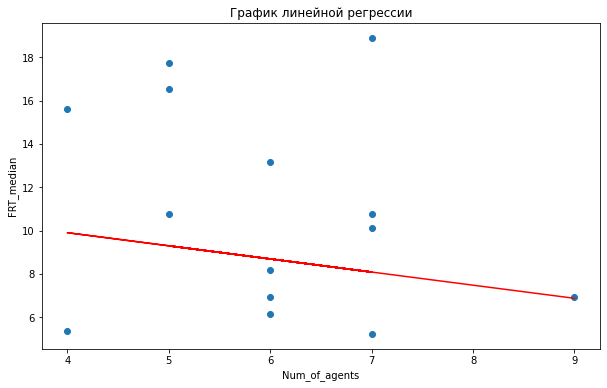

Изменение медианы времени первого ответа в зависимости от количества агентов на смене [[6.]]


In [26]:
lr_agents_mrt = perform_linear_regression(final_by_date['Num_of_agents'].values, final_by_date['FRT_median'].values, 'Num_of_agents', 'FRT_median')
print('Изменение медианы времени первого ответа в зависимости от количества агентов на смене', np.round(lr_agents_mrt.predict(np.array([10]).reshape(1, -1))))

## Создадим модель для предсказания медианного времени ответа при заданном количестве активных клиентов

In [27]:
# посмотрим на среднюю квадратичную ошибку и среднюю абсолютную ошибку при различных сочетаниях аргументов:
def regression(predict_list, predict_goal):
  X = final_by_date[predict_list]
  Y = final_by_date[predict_goal]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 15)
  linear_regressor = LinearRegression()  # create an instance of the class
  linear_regressor.fit(X_train, Y_train)  # perform linear regression
  Y_pred = linear_regressor.predict(X_test)  # make predictions

  print("Предсказываем " + predict_goal + " используя " + str(predict_list))
  print('Средняя квадратичная ошибка:', mse(Y_test, Y_pred))
  print('Средняя абсолютная ошибка:', mae(Y_test, Y_pred), "\n")

  return linear_regressor

In [28]:
regression(['Num_of_active', 'Num_of_agents', 'Num_of_chats'], 'FRT_median')
regression(['Num_of_agents', 'Num_of_chats'], 'FRT_median')
regression(['Num_of_active', 'Num_of_agents'], 'FRT_median')
regression(['Num_of_active', 'Num_of_chats'], 'FRT_median');

Предсказываем FRT_median используя ['Num_of_active', 'Num_of_agents', 'Num_of_chats']
Средняя квадратичная ошибка: 5.919235666809944
Средняя абсолютная ошибка: 1.9953614407182965 

Предсказываем FRT_median используя ['Num_of_agents', 'Num_of_chats']
Средняя квадратичная ошибка: 6.177002949049009
Средняя абсолютная ошибка: 2.046258633998455 

Предсказываем FRT_median используя ['Num_of_active', 'Num_of_agents']
Средняя квадратичная ошибка: 6.155947897440032
Средняя абсолютная ошибка: 2.0119901055016705 

Предсказываем FRT_median используя ['Num_of_active', 'Num_of_chats']
Средняя квадратичная ошибка: 8.876741698624436
Средняя абсолютная ошибка: 2.325478865515986 



Тут видим, что наименьшая ошибка на выходе у модели для которой мы используем показатели ['Num_of_active', 'Num_of_agents', 'Num_of_chats'], но так как Num_of_active и Num_of_chats сильно кореллируют друг с другом, то лучше не использовать их вместе для предсказания третьего параметра. 

## Модель DecisionTreeRegressor для предсказания медианы времени первого ответа при заданном количестве активных клиентов и агентов на смене в день

In [29]:
# Чтобы избежать переобучение модели, определим оптимальную глубину дерева (max_depth). Спойлер: max_depth = 3
param_grid = {'max_depth': [3, 5, 7, 10]}
dr = DecisionTreeRegressor()
X = final_by_date[['Num_of_active', 'Num_of_agents']]
Y = final_by_date['FRT_median']
sh = GridSearchCV(dr, param_grid).fit(X, Y)
sh.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [30]:
X = final_by_date[['Num_of_active', 'Num_of_agents']]
Y = final_by_date['FRT_median']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=15)
dr = DecisionTreeRegressor(max_depth=3)
dr.fit(X_train, Y_train)
Y_pred = dr.predict(X_test)

print('Средняя квадратичная ошибка:', mse(Y_test, Y_pred))
print('Средняя ошибка:', mae(Y_test, Y_pred))

print('Ожидаемое медианное время первого ответа клиенту (минут): ', np.round(dr.predict(np.array([1000, 9]).reshape(1, -1)), decimals=2))

Средняя квадратичная ошибка: 8.682450612427113
Средняя ошибка: 2.323472789115647
Ожидаемое медианное время первого ответа клиенту (минут):  [7.45]


## Модель RandomForestRegressor для предсказания медианы времени первого ответа при заданном количестве активных клиентов и агентов на смене в день

In [31]:
#определим оптимальную глубину дерева (max_depth)
param_grid = {'max_depth': [3, 5, 7, 10]}
rf_reg = RandomForestRegressor()
X = final_by_date[['Num_of_chats', 'Num_of_agents']]
Y = final_by_date['FRT_median']
sh = GridSearchCV(rf_reg, param_grid).fit(X, Y)
sh.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [32]:
X = final_by_date[['Num_of_chats', 'Num_of_agents']]
Y = final_by_date['FRT_median']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=15)
rf_reg = RandomForestRegressor(max_depth = 3)
rf_reg.fit(X_train, Y_train)
Y_pred = rf_reg.predict(X_test)  

print('Средняя квадратичная ошибка:', mse(Y_test, Y_pred))
print('Средняя ошибка:', mae(Y_test, Y_pred))
rf_reg.predict(np.array([228, 5]).reshape(1, -1))

Средняя квадратичная ошибка: 8.087102837917808
Средняя ошибка: 2.111632600827075


array([12.12846195])

## Модель линейной регрессии для предсказания медианы времени первого ответа при заданном количестве активных клиентов и агентов на смене в день

In [33]:
lr = regression(['Num_of_active', 'Num_of_agents'], 'FRT_median')
print('Ожидаемое медианное время первого ответа клиенту (минут): ', np.round(lr.predict(np.array([1000, 9]).reshape(1, -1)), decimals=2))

Предсказываем FRT_median используя ['Num_of_active', 'Num_of_agents']
Средняя квадратичная ошибка: 6.155947897440032
Средняя абсолютная ошибка: 2.0119901055016705 

Ожидаемое медианное время первого ответа клиенту (минут):  [19.67]



Исходя из проведенного исследования, можно сделать вывод, что модель линейной регрессии lr является самой точной из изученных в проекте. У нее наименьшая средняя абсолютная ошибка.